# ДЗ 3. Коллаборативная фильтрация

1) Попытаться ответить на вопросы/выдвинуть гипотезы

2) Доделать прошлые домашния задания

3) Прочитать статьи BM25/MatrixFactorization

4) Поэкспериментировать с ALS (grid-search)

### 1. Попытаться ответить на вопросы/выдвинуть гипотезы

# Production

Начиная с этого вебинара, мы будем строить *базовое решение* для системы рекомендаций топ-N товаров. В финальном проекте вам нужно будет его сущесвтенно улучшить.  
  
**Ситуация**: Вы работает data scientist в крупном продуктовом российском ритейлере. Ваш конкурент сделал рекомендательную систему, и его продажи выросли. Ваш менеджмент тоже хочет увеличить продажи   
**Задача со слов менеджера**: Сделайте рекомендательную систему топ-10 товаров для рассылки по e-mail

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)
- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше) **Бизнес метрики почти всегда отличаются от метрик ML**


- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они? **Ответственные отделы должнызаниматься сбором e-mail.**

- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе? **Возможно, лучше диверсифицировать. Например, какую то категорию товаров (например эксклизив) присылать по почте, а в уведомлениях повседневные предложения**

- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?) **Лучшее количество рекоммендаций - от 2-х до 5**

- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)? **По почте  лучше присылать товары, с более значемой ценовой категориет и долгосрочные акции.**

- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки **Потраченных денег должно быть меньше, чем прибыль на которую мы расчитывает или меньше чем убытки, которых мы планируем избежать.**

- Cколько мы хотим зарабатывать с одного привлеченного юзера? **Больше, чем потрачено**

---
- А точно нужно сортировать по вероятности? **Можно вероятность взвешивать по цене. Или просто фильтровать товары определенной ценовой категории и из них уже сортировать по вероятности**

- Какую метрику использовать? **Для качества метрики ML.  Для поставленных задач бизнес-метрики.**

- Сколько раз в неделю отпрпавляем рассылку? **Для этого можно составить модель и сегментировать пользователей. Или задействовать отдел маркетологов**

- В какое время отправляем рассылку? **Это зависит от выбранной коммуникации. Например,смс лучше когда большая вероятность, что человек свободен в обеденный перерыв.**

- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались? **Можно микшировать топ товаров, с популярными и не вошедшими в топ, или часть рандомно.**

- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными? **Возможно, это разность можно определить, если расстояние между эмбеддингами больше определенного значения, и если товары в разных категориях.**


### 4. Поэкспериментировать с ALS (grid-search)

Подключим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k

Разобьем по времени датасет на трейн и тест:

In [109]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


Сформируем тестовый результирующий датасет:

In [110]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


Выделим топ-5000 товаров, для непопулярных товаров заведем фиктивный id, и составим матрицу user_item:

In [111]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [112]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\Users\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Составим словари для матчинга пользователей и товаров в модели:

In [6]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

Функция получения рекоммендаций для каждого пользователя:

In [7]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

Функция обхода по сетке для параметров factors и iterations в модели ALS. Также в качестве параметра функция получает значение регуляризации и метод взвешивания user_item_matrix.

In [58]:
def search(regularization, factors_list, iterations_list, user_item_matrix, weighted_method=None):
    
    metrics_matrix = []
    
    for factors in factors_list:
        
        row = []
        
        for iterations in iterations_list:
        
            model = AlternatingLeastSquares(factors=factors, 
                                            regularization=regularization,
                                            iterations=iterations, 
                                            calculate_training_loss=True, 
                                            num_threads=4)
                
            if weighted_method == 'tfidf':
                user_item_matrix = tfidf_weight(user_item_matrix.T).T
            elif weighted_method == 'bm25':
                user_item_matrix = bm25_weight(user_item_matrix.T).T
            
            model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
                      show_progress=True)

            tmp_df = result[['actual']]

            tmp_df['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
            row.append(tmp_df.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
            
        metrics_matrix.append(row)
        
    return metrics_matrix

### Поиск по сетке

**Произведем поиск по сетке для следующих параметров:**

- factors_list = [50, 60, 70, 80, 90, 100]
- iterations_list = [15, 16, 17, 18, 19, 20]
- regularizations - 0.001, 0.005, 0.01, 0.05, 0.1, 0.5
- метод взвешивания - None, tfidf, bm25

In [55]:
%%time

factors_list = [50, 60, 70, 80, 90, 100]
iterations_list = [15, 16, 17, 18, 19, 20]
metrics_matrix_001 = search(.001, factors_list, iterations_list, user_item_matrix)


Wall time: 46min 40s


Функция отрисовки матрицы метрик для заданных параметров:

In [48]:
def plot_metrics_matrix(metrics_matrix, columns, indexes, regularization):
    matrix = pd.DataFrame(metrics_matrix, columns=columns)
    matrix.set_index(pd.Index(indexes), inplace=True)
    plt.figure(figsize=(12,12))
    sns.heatmap(matrix, 
                cmap='YlGn',
                annot=True, annot_kws = { "size" : 10 }, fmt='.4g', square=True)
    plt.ylabel('factors')
    plt.xlabel('iterations')
    plt.title(f'Metrics matrix for regularization={str(regularization)}')
    plt.show()

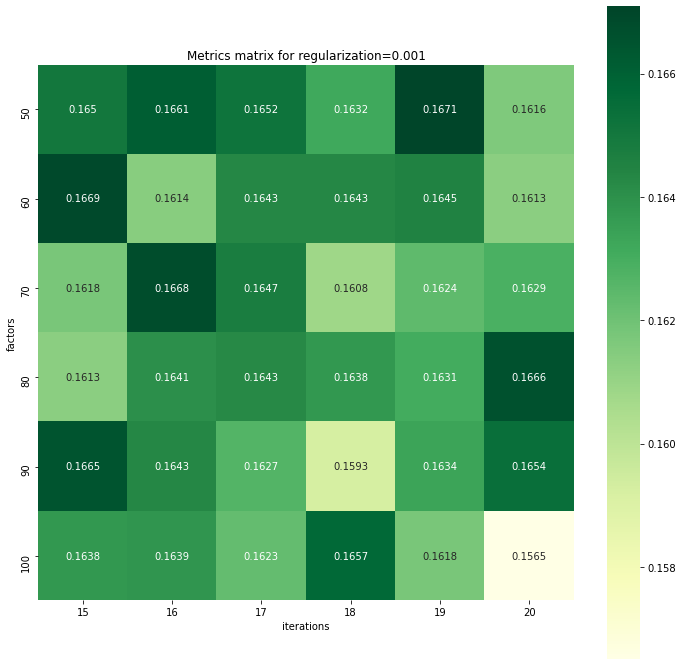

In [56]:
plot_metrics_matrix(metrics_matrix_001, iterations_list, factors_list, .001)

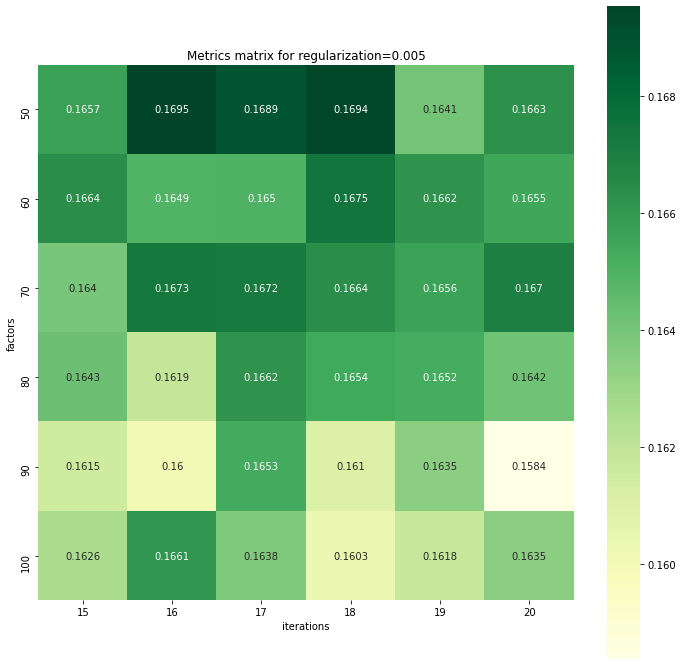

Wall time: 45min 37s


In [59]:
%%time

metrics_matrix_005 = search(.005, factors_list, iterations_list, user_item_matrix)
plot_metrics_matrix(metrics_matrix_005, iterations_list, factors_list, .005)

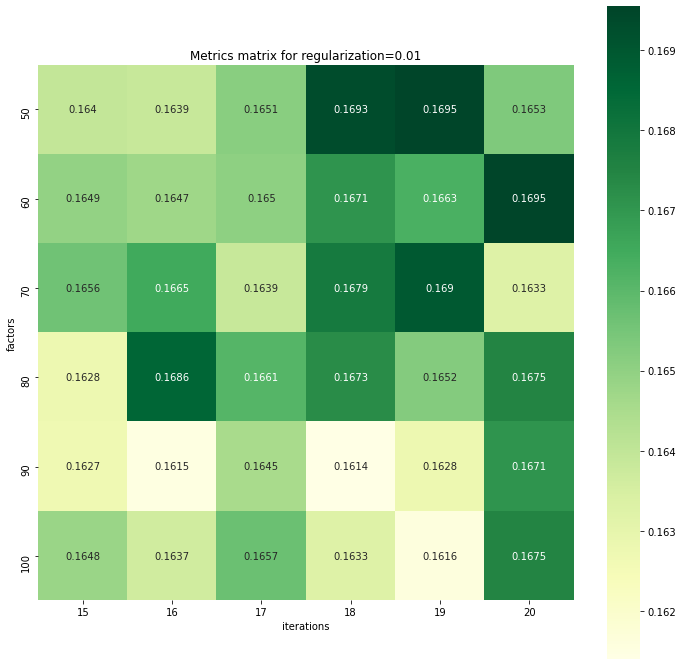

Wall time: 49min 36s


In [60]:
%%time

metrics_matrix_01 = search(.01, factors_list, iterations_list, user_item_matrix)
plot_metrics_matrix(metrics_matrix_01, iterations_list, factors_list, .01)

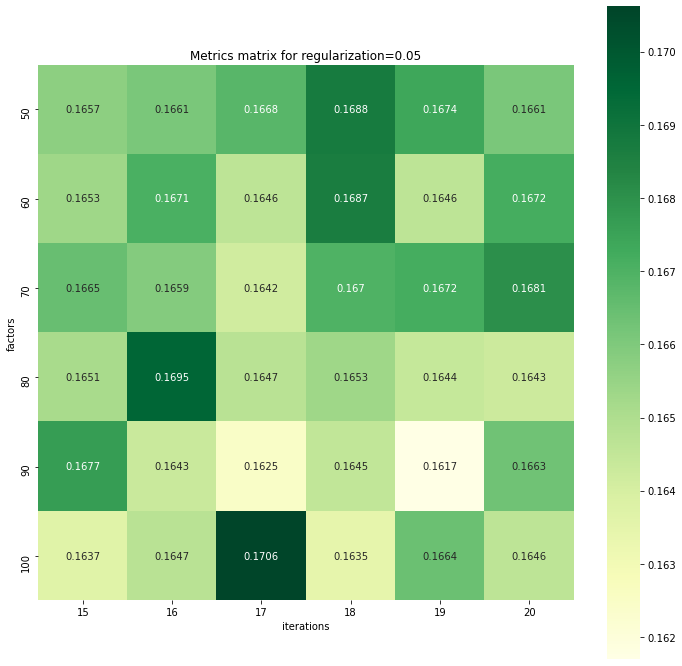

Wall time: 44min 32s


In [61]:
%%time

metrics_matrix_05 = search(.05, factors_list, iterations_list, user_item_matrix)
plot_metrics_matrix(metrics_matrix_05, iterations_list, factors_list, .05)

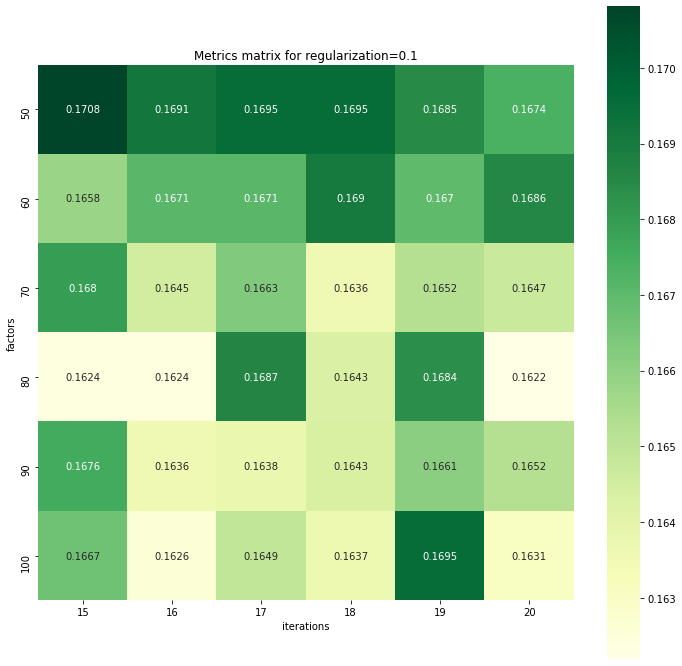

Wall time: 45min 39s


In [62]:
%%time

metrics_matrix_1 = search(.1, factors_list, iterations_list, user_item_matrix)
plot_metrics_matrix(metrics_matrix_1, iterations_list, factors_list, .1)

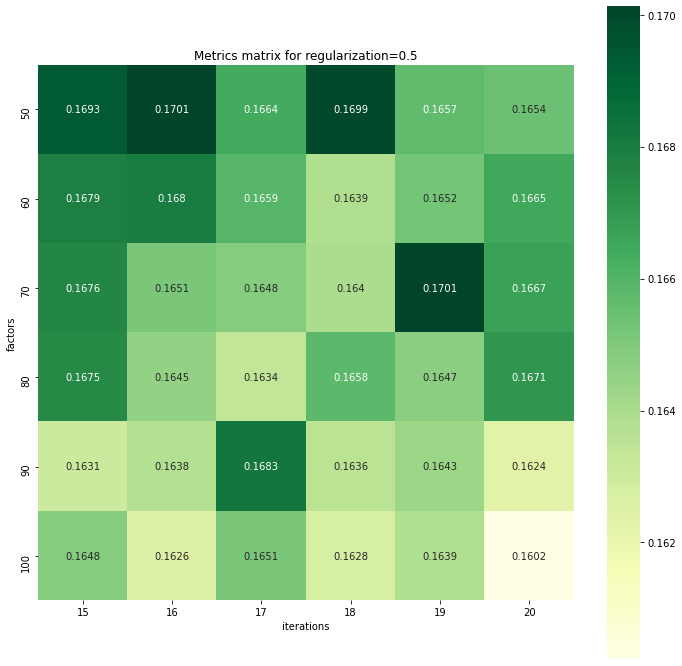

Wall time: 43min 15s


In [63]:
%%time

metrics_matrix_5 = search(.5, factors_list, iterations_list, user_item_matrix)
plot_metrics_matrix(metrics_matrix_5, iterations_list, factors_list, .5)

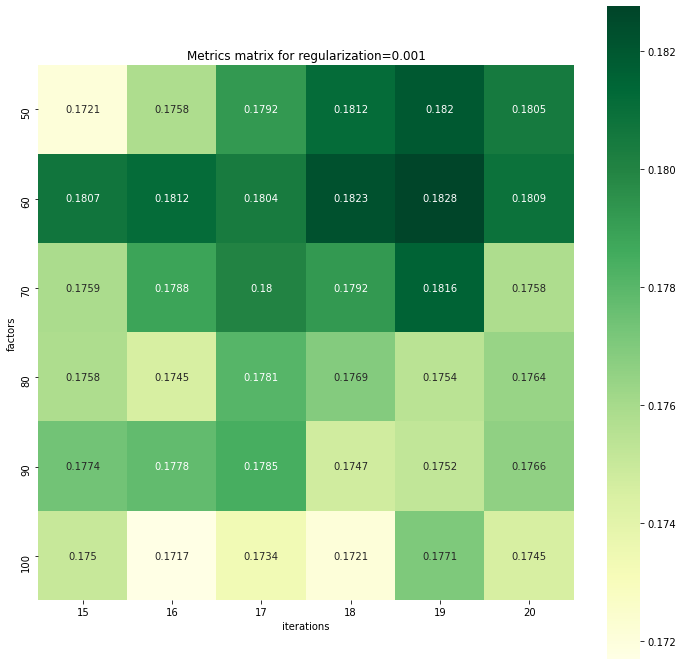

Wall time: 43min 55s


In [64]:
%%time

metrics_matrix_001_tfidf = search(.001, factors_list, iterations_list, user_item_matrix, 'tfidf')
plot_metrics_matrix(metrics_matrix_001_tfidf, iterations_list, factors_list, .001)

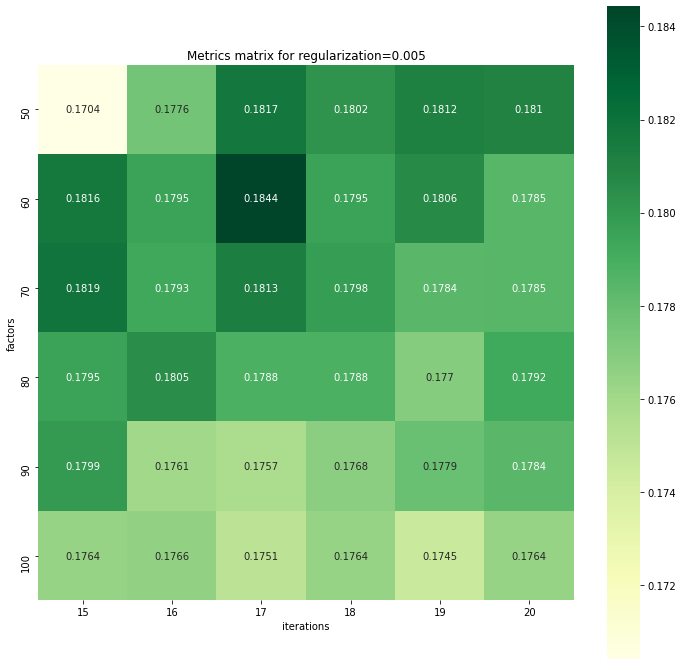

Wall time: 44min 2s


In [65]:
%%time

metrics_matrix_005_tfidf = search(.005, factors_list, iterations_list, user_item_matrix, 'tfidf')
plot_metrics_matrix(metrics_matrix_005_tfidf, iterations_list, factors_list, .005)

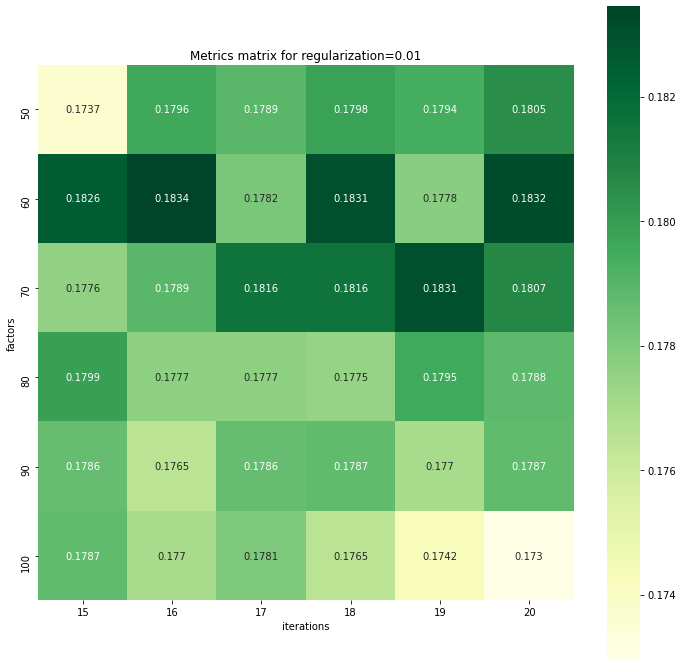

Wall time: 44min 14s


In [66]:
%%time

metrics_matrix_01_tfidf = search(.01, factors_list, iterations_list, user_item_matrix, 'tfidf')
plot_metrics_matrix(metrics_matrix_01_tfidf, iterations_list, factors_list, .01)

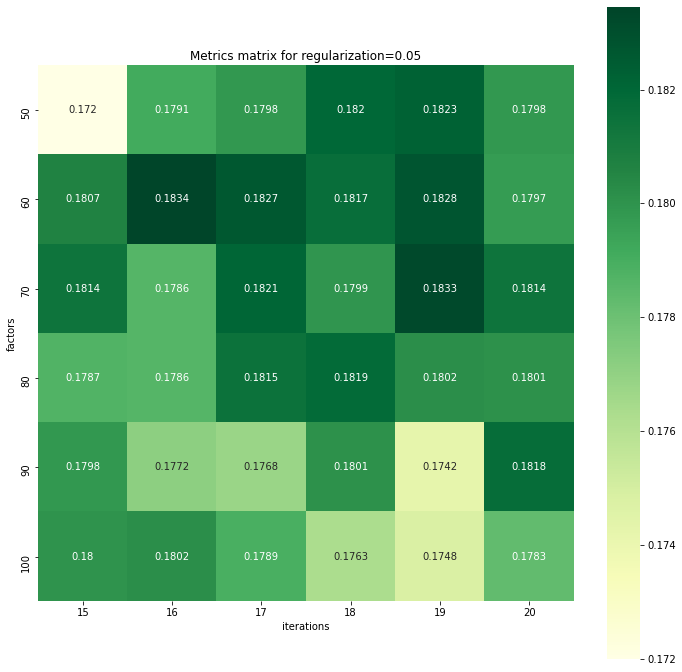

Wall time: 44min 18s


In [67]:
%%time

metrics_matrix_05_tfidf = search(.05, factors_list, iterations_list, user_item_matrix, 'tfidf')
plot_metrics_matrix(metrics_matrix_05_tfidf, iterations_list, factors_list, .05)

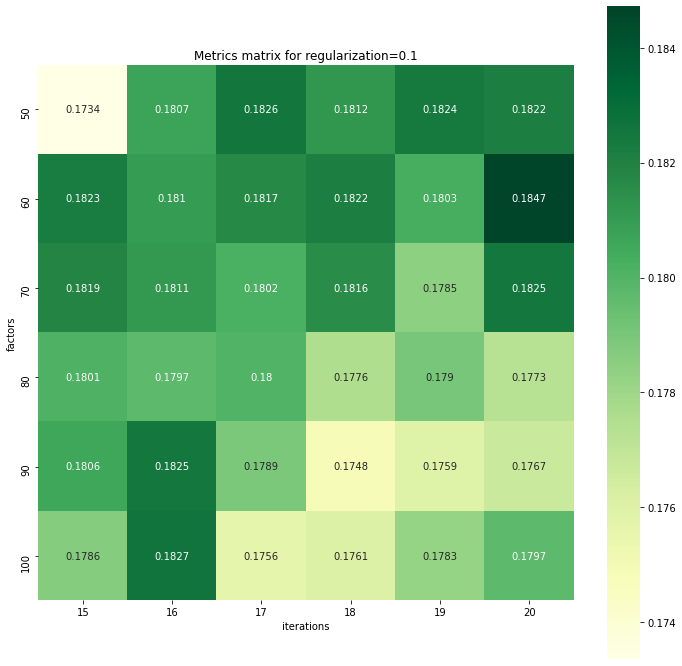

Wall time: 44min 7s


In [68]:
%%time

metrics_matrix_1_tfidf = search(.1, factors_list, iterations_list, user_item_matrix, 'tfidf')
plot_metrics_matrix(metrics_matrix_1_tfidf, iterations_list, factors_list, .1)

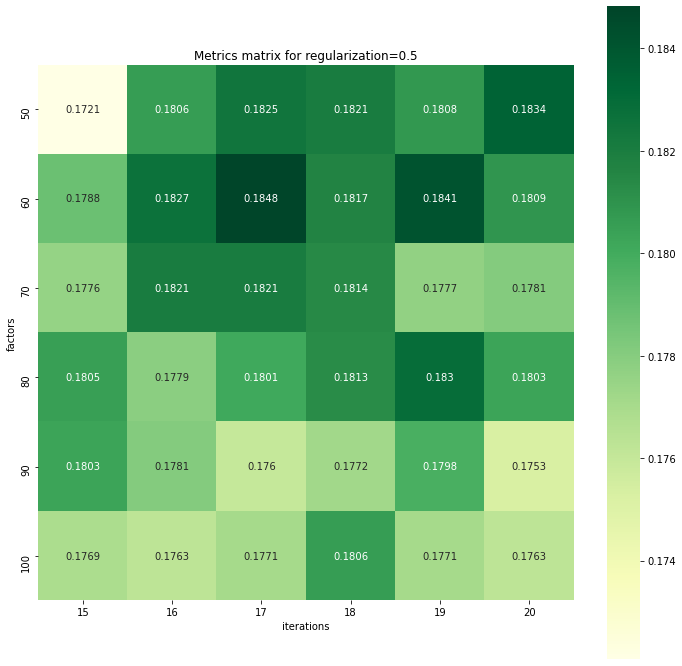

Wall time: 44min 18s


In [69]:
%%time

metrics_matrix_5_tfidf = search(.5, factors_list, iterations_list, user_item_matrix, 'tfidf')
plot_metrics_matrix(metrics_matrix_5_tfidf, iterations_list, factors_list, .5)

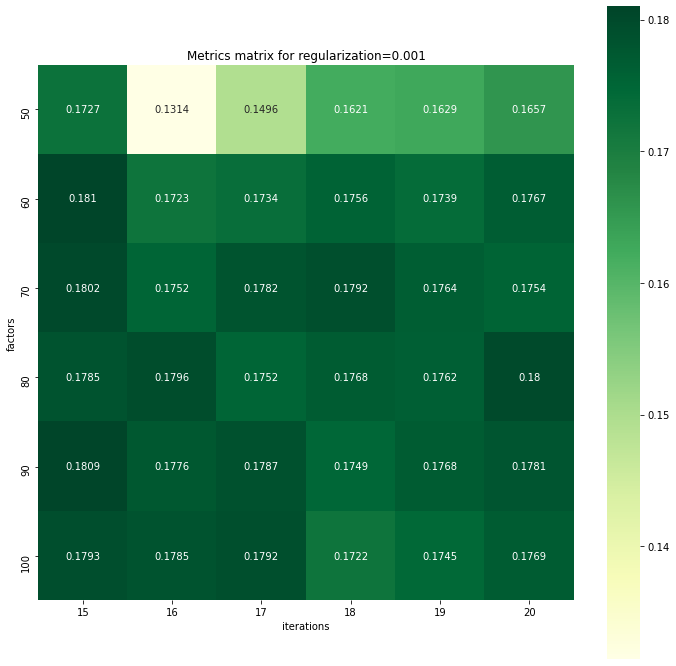

Wall time: 44min 30s


In [70]:
%%time

metrics_matrix_001_bm25 = search(.001, factors_list, iterations_list, user_item_matrix, 'bm25')
plot_metrics_matrix(metrics_matrix_001_bm25, iterations_list, factors_list, .001)

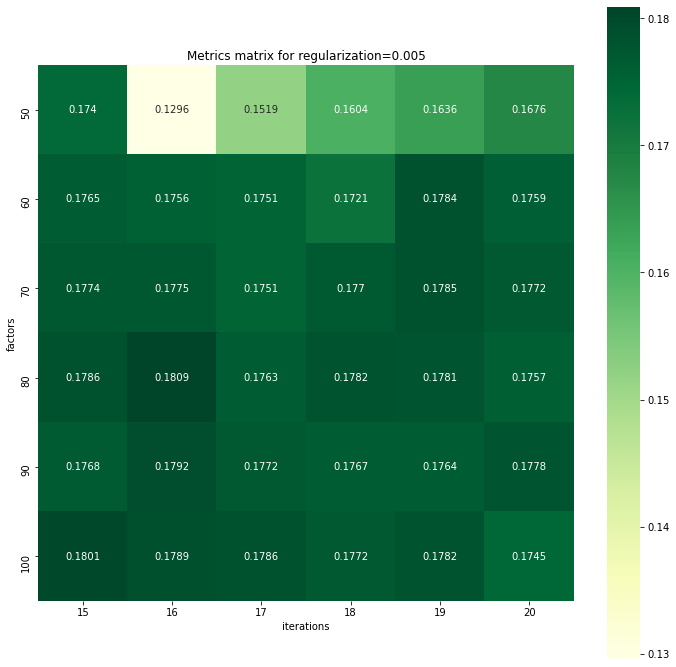

Wall time: 45min 34s


In [71]:
%%time

metrics_matrix_005_bm25 = search(.005, factors_list, iterations_list, user_item_matrix, 'bm25')
plot_metrics_matrix(metrics_matrix_005_bm25, iterations_list, factors_list, .005)

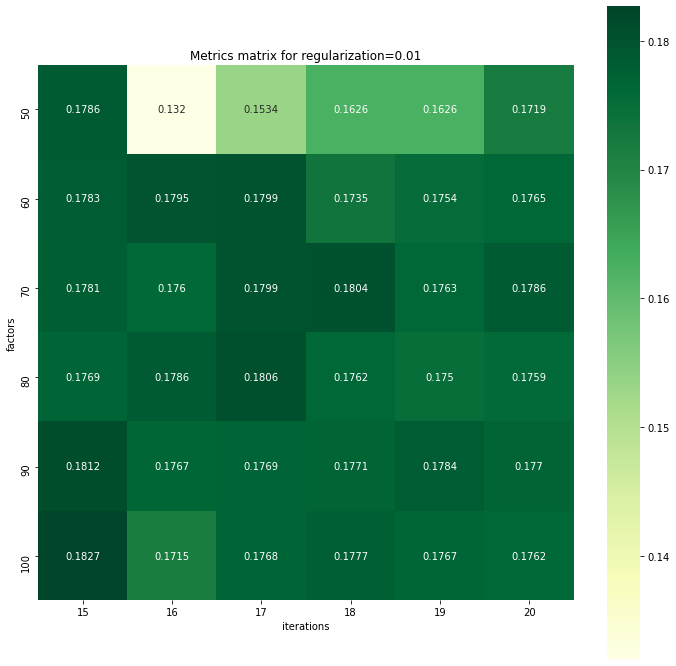

Wall time: 45min 41s


In [72]:
%%time

metrics_matrix_01_bm25 = search(.01, factors_list, iterations_list, user_item_matrix, 'bm25')
plot_metrics_matrix(metrics_matrix_01_bm25, iterations_list, factors_list, .01)

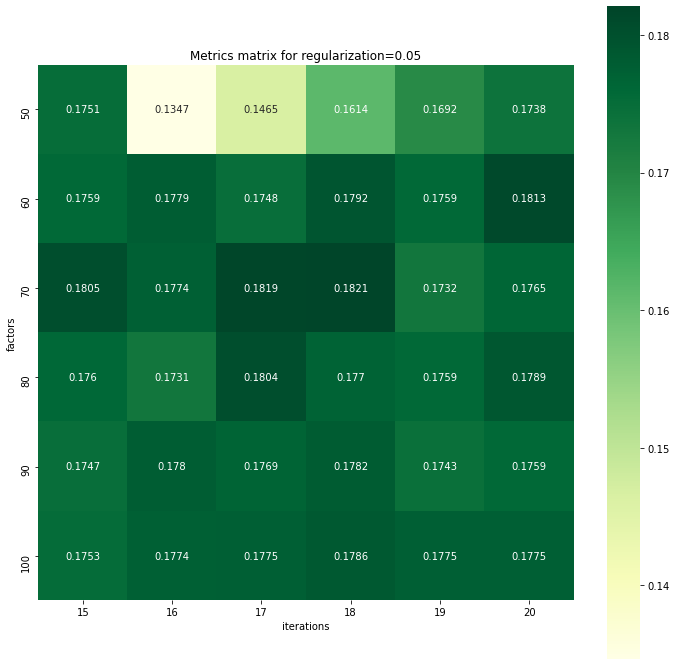

Wall time: 45min 22s


In [73]:
%%time

metrics_matrix_05_bm25 = search(.05, factors_list, iterations_list, user_item_matrix, 'bm25')
plot_metrics_matrix(metrics_matrix_05_bm25, iterations_list, factors_list, .05)

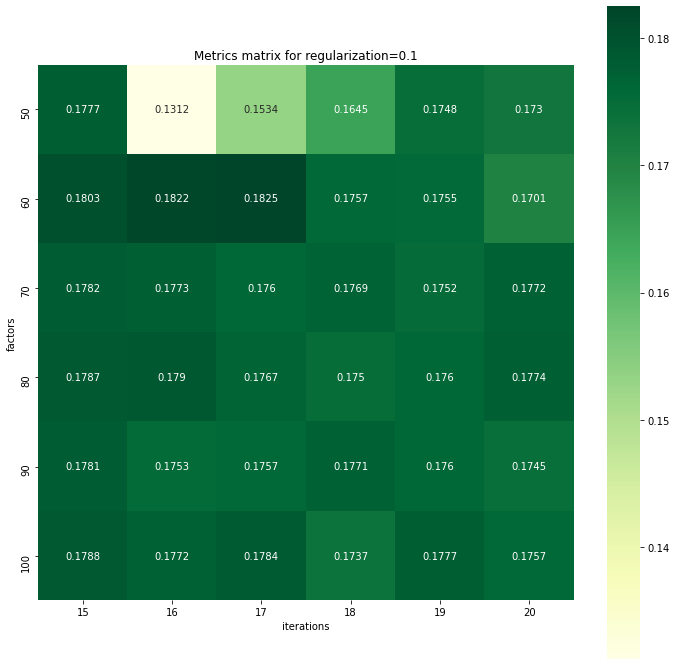

Wall time: 45min 50s


In [74]:
%%time

metrics_matrix_1_bm25 = search(.1, factors_list, iterations_list, user_item_matrix, 'bm25')
plot_metrics_matrix(metrics_matrix_1_bm25, iterations_list, factors_list, .1)

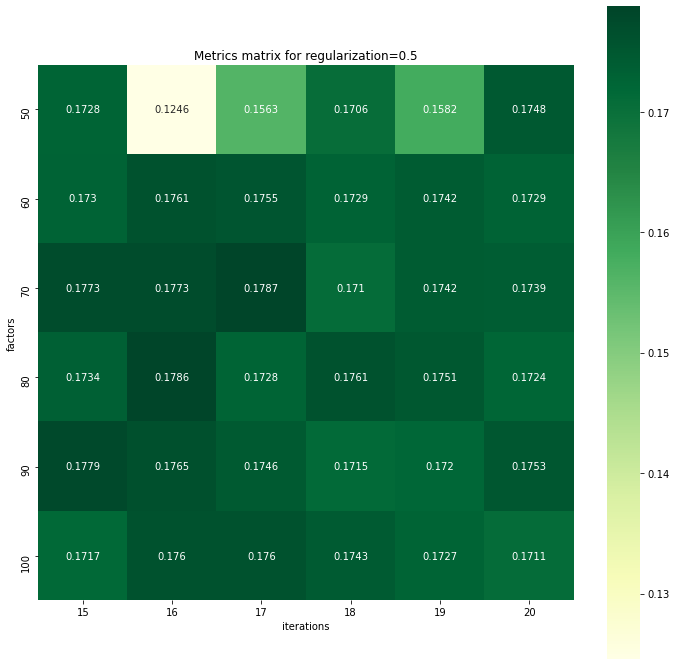

Wall time: 45min 42s


In [75]:
%%time

metrics_matrix_5_bm25 = search(.5, factors_list, iterations_list, user_item_matrix, 'bm25')
plot_metrics_matrix(metrics_matrix_5_bm25, iterations_list, factors_list, .5)

**Итак, после 13 часов прохода по параметрам, лучшую метрику precision_at_k в 0.1848 дали следующие параметры:**

- взвешивание user_item_matrix - tfidf,
- regularizations - 0.5
- factors - 60
- iterations - 17

Попробуем для этих параметров при получении рекоммендаций отфильтровать непопулярные товары (фиктивный user_id):

In [124]:
model = AlternatingLeastSquares(factors=60, 
                                regularization=.5,
                                iterations=17, 
                                calculate_training_loss=True,
                                random_state=42,
                                num_threads=4)
                
uim = tfidf_weight(user_item_matrix.T).T

model.fit(csr_matrix(uim).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

tmp_df = result[['actual']]

tmp_df['als'] = result['user_id'].\
                apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                                    model.recommend(userid=userid_to_id[x], 
                                                    user_items=sparse_user_item,   # на вход user-item matrix
                                                    N=5, 
                                                    filter_already_liked_items=False, 
                                                    filter_items=[itemid_to_id[999999]], 
                                                    recalculate_user=True)])

tmp_df.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

0.19520078354554096

Дополнительная фильтрация дает прирост, по сравнению с первоначальным 0.16. 